In [61]:
import os
import json
import sys

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import utils
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN

import plotly.express as px
import plotly.io as pio

from plotly import graph_objects as go
from plotly.subplots import make_subplots

from zca import ZCA
# pio.renderers.default = 'notebook_connected' # set to 'svg' or 'png' for static plots
pio.renderers.default = 'png'

### Read data

In [62]:
df = pd.read_csv("NW-S_tsne.txt", sep = "\t")

In [63]:
df = df.fillna(0).T

In [64]:
print(df.shape)
print(np.sqrt(35))

(35, 131)
5.916079783099616


In [65]:
df.columns = df.loc['nt']

In [66]:
df = df.iloc[1:, :]

In [67]:
df.columns

Index(['T:21528:C:Leu10Pro', 'A:21529::Val11fs', 'G:21545:T:Val16Phe',
       'T:21626:C:Phe43Leu', 'T:21660:C:Leu54Ser', 'T:21671:C:Phe58Leu',
       'T:21689:A:Trp64Arg', 'A:21696:G:His66Arg', 'G:21698:T:Ala67Ser',
       ':21713:A:Asn72fs',
       ...
       'T:24945:C:Leu1149Ser', ':25029:A:Glu1179fs', 'G:25094:C:Glu1199Gln',
       'A:25104:G:Lys1202Arg', 'T:25124:C:Trp1209Arg', 'G:25145:T:Gly1216Cys',
       'T:25191:C:Leu1231Pro', 'G:25206:C:Ser1236Thr', 'G:25251:C:Cys1251Ser',
       'G:25268:T:Asp1257Tyr'],
      dtype='object', name='nt', length=131)

In [68]:
df.head()

nt,T:21528:C:Leu10Pro,A:21529::Val11fs,G:21545:T:Val16Phe,T:21626:C:Phe43Leu,T:21660:C:Leu54Ser,T:21671:C:Phe58Leu,T:21689:A:Trp64Arg,A:21696:G:His66Arg,G:21698:T:Ala67Ser,:21713:A:Asn72fs,...,T:24945:C:Leu1149Ser,:25029:A:Glu1179fs,G:25094:C:Glu1199Gln,A:25104:G:Lys1202Arg,T:25124:C:Trp1209Arg,G:25145:T:Gly1216Cys,T:25191:C:Leu1231Pro,G:25206:C:Ser1236Thr,G:25251:C:Cys1251Ser,G:25268:T:Asp1257Tyr
P-1-NW-1DPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P-1-NW-3DPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.082251,0.0,0.0,0.0,0.0
P-1-NW-4DPC,0.0,0.0,0.0,0.0,0.0,0.0,1.590984,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.640845,0.0,0.0,0.0
P-2-NW-1DPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P-2-NW-3DPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
location = pd.Series(df.index).map(lambda x: '-'.join(x.split('-')[:1]))

In [70]:
location

0      P
1      P
2      P
3      P
4      P
5      P
6      P
7      P
8      P
9      P
10     P
11     P
12     P
13     P
14     P
15    NP
16    NP
17    NP
18    NP
19    NP
20    NP
21    NP
22    NP
23    NP
24    NP
25    NP
26    CO
27    CO
28    CO
29    CO
30    CO
31    CO
32    CO
33    CO
dtype: object

### Clustering using hdbscan

In [71]:
clusterer = HDBSCAN().fit(df)

In [72]:
clusterID = pd.Series(clusterer.labels_).apply(lambda x: str(x))

In [73]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

### TSNE projections

In [74]:
tsne = TSNE(n_components = 2, perplexity = 10, random_state = 123)
tsne_results = tsne.fit_transform(df)

/home/ec2-user/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/ec2-user/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [75]:
tsne_df = pd.DataFrame({"tsne-1": tsne_results[:, 0],
                       "tsne-2": tsne_results[:, 1], 
                      "sampleID": df.index, 
                       'locale': location})

In [76]:
fig = px.scatter(tsne_df, x = "tsne-1", y = "tsne-2", hover_data = ['sampleID'], color = 'locale', height = 600, width = 800)

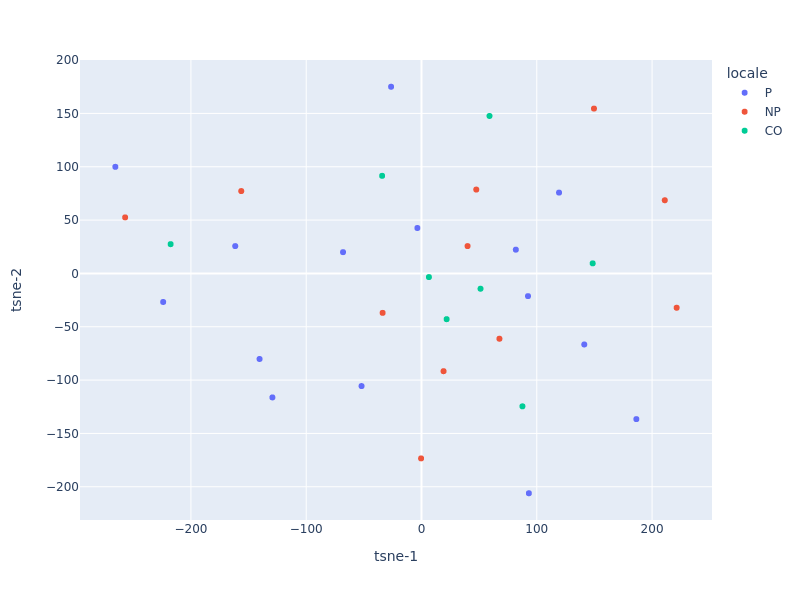

In [77]:
fig.show()

### UMAP projections

In [78]:
from umap import UMAP

In [79]:
umap_2d = UMAP(n_components = 2, random_state = 123).fit_transform(df)

In [80]:
umap_df = pd.DataFrame({"umap-1":umap_2d[:, 0],
                       "umap-2": umap_2d[:, 1], 
                      "sampleID": df.index, 
                      "locale": location})

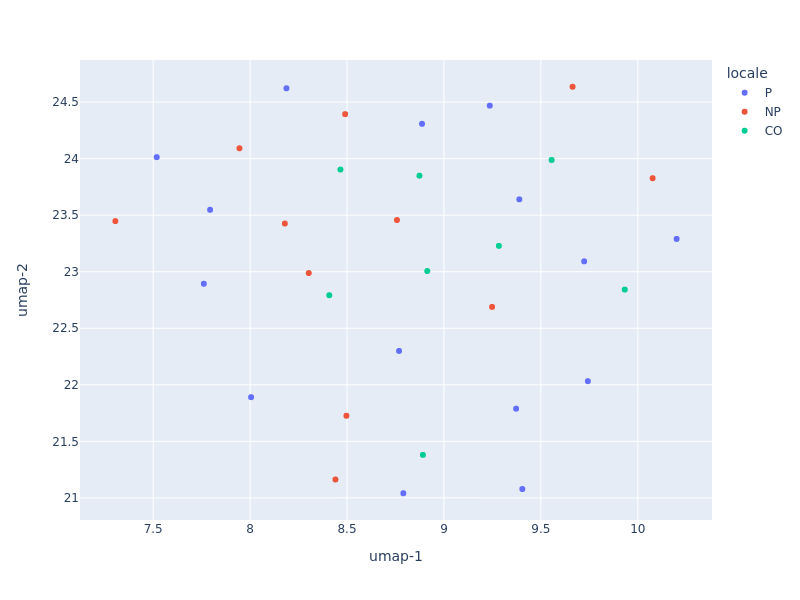

In [81]:
px.scatter(umap_df, x = 'umap-1', y = 'umap-2', hover_data = ['sampleID'], color = 'locale', height = 600, width = 800)